<a href="https://colab.research.google.com/github/elifftosunn/Bert-Bank-Model/blob/main/MultiClassificationWithMLAlgorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import shutil
import sys
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.model_selection import train_test_split

from nltk.tokenize import sent_tokenize, word_tokenize

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')  

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
import pickle
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
!nvidia-smi

Thu Feb  2 14:51:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
df = pd.read_csv("/content/drive/MyDrive/datas/cleanBankData2.csv")
df

name  \
0               MOOV Mov Uyarı Vermeden Kısıtlama Getirdi   
1       Ziraat Bankası Bankkart Arka Yüzündeki Kredi K...   
2       Hepsiburada.com Sipariş İptaliyle 500 TL Zarar...   
3                        Ziraat Bankası Borç Ödeme Sorunu   
4                        Ziraat Bankası Bloke Açma Sorunu   
...                                                   ...   
246407                KKB'de Borçlarım Ödenmedi Gözüküyor   
246408                            İş Bankası İlgisizliği!   
246409          Garanti Bankası Her Şey Gönlünüzce Olsun!   
246410            ING Bank Ticari Kredi Kartı Alamıyorum!   
246411             TEB İnsanları Mağdur Ediyor, Aldatıyor   

                                                     link            label  \
0       https://www.sikayetvar.com/moov/moov-mov-uyari...  Kredi İşlemleri   
1       https://www.sikayetvar.com/ziraat-bankasi/zira...  Kredi İşlemleri   
2       https://www.sikayetvar.com/hepsiburada/hepsibu...  Kredi İşlemleri   
3       https://www.sikayetvar.com/ziraat-bankasi/zira...  Kredi İşlemleri   
4       https://www.sikayetvar.com/ziraat-bankasi/zira...  Kredi İşlemleri   
...                                                   ...              ...   
246407  https://www.sikayetvar.com/kredi-kayit-burosu/...         KKB Skor   
246408  https://www.sikayetvar.com/is-bankasi/is-banka...         KKB Skor   
246409  https://www.sikayetvar.com/garanti-bbva/garant...         KKB Skor   
246410  https://www.sikayetvar.com/ing/ing-bank-ticari...         KKB Skor   
246411  https://www.sikayetvar.com/teb/teb-insanlari-m...         KKB Skor   

                                                     text  
0       moov ad araç kiralamak şirket sürek araç kiral...  
1       ziraat banka bankkart kart kredi kart alışveri...  
2       22 ara 2022 tarih hepsiburadacomdan yapmak 475...  
3       banka kart par olmak rağmen kredi kart bor öde...  
4       ziraat banka kredi bor dolay hesap bloke koyma...  
...                                                   ...  
246407  2011 yıl çeşit banka borç var var şirket aracı...  
246408  2010 yıl açtırdığım 2015 yıl kapanan kredi kar...  
246409  merhaba müşteri no 16790602 kkb 1589 3 ay şâhı...  
246410  yaklaşık 1 yıldır pos hesap kul kkb puan yeter...  
246411  teb kredi kart başvuru yaptım 12122018 9 bin t...  

[246412 rows x 4 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246412 entries, 0 to 246411
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name    246412 non-null  object
 1   link    246412 non-null  object
 2   label   246412 non-null  object
 3   text    246412 non-null  object
dtypes: object(4)
memory usage: 7.5+ MB


In [7]:
df = df.drop(["name", "link"], axis = 1)
df

label                                               text
0       Kredi İşlemleri  moov ad araç kiralamak şirket sürek araç kiral...
1       Kredi İşlemleri  ziraat banka bankkart kart kredi kart alışveri...
2       Kredi İşlemleri  22 ara 2022 tarih hepsiburadacomdan yapmak 475...
3       Kredi İşlemleri  banka kart par olmak rağmen kredi kart bor öde...
4       Kredi İşlemleri  ziraat banka kredi bor dolay hesap bloke koyma...
...                 ...                                                ...
246407         KKB Skor  2011 yıl çeşit banka borç var var şirket aracı...
246408         KKB Skor  2010 yıl açtırdığım 2015 yıl kapanan kredi kar...
246409         KKB Skor  merhaba müşteri no 16790602 kkb 1589 3 ay şâhı...
246410         KKB Skor  yaklaşık 1 yıldır pos hesap kul kkb puan yeter...
246411         KKB Skor  teb kredi kart başvuru yaptım 12122018 9 bin t...

[246412 rows x 2 columns]

In [8]:
df.label.value_counts()

Kart İşlemleri        37296
Kredi İşlemleri       36904
Diğer                 36626
Hesap İşlemleri       36504
Kargo                 35392
Limit                 30802
Müşteri Temsilcisi    20266
KKB Skor              12622
Name: label, dtype: int64

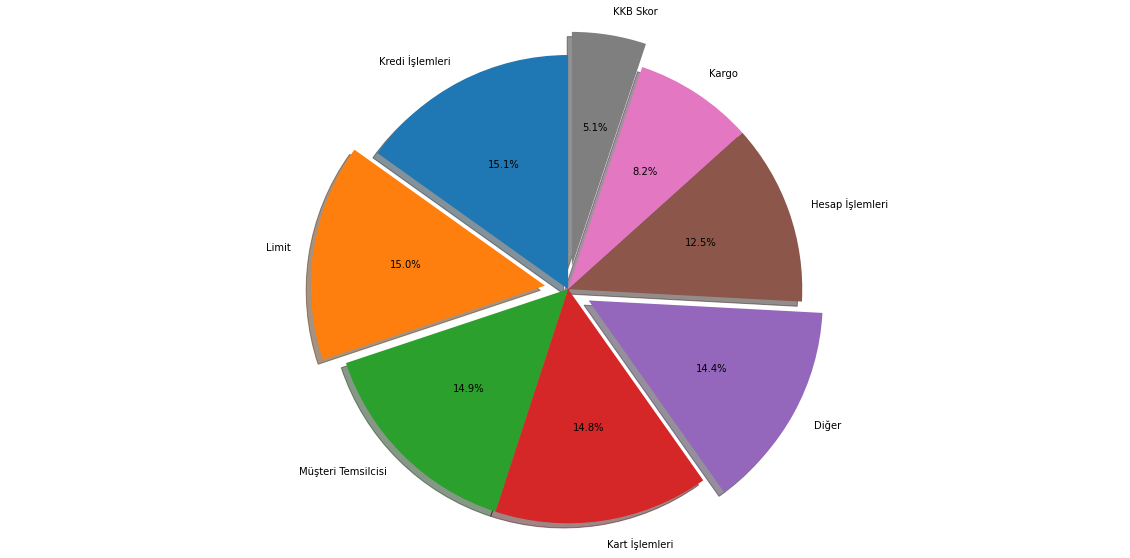

In [9]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df.label.unique()
sizes = df.label.value_counts()
explode = (0, 0.1, 0, 0, 0.1, 0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize = (20,10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [10]:
kartDf = df.loc[df.label == "Kart İşlemleri"]
krediDf = df.loc[df.label == "Kredi İşlemleri"]
digerDf = df.loc[df.label == "Diğer"]
hesapDf = df.loc[df.label == "Hesap İşlemleri"]
cargoDf = df.loc[df.label == "Kargo"]
limitDf = df.loc[df.label == "Limit"]
musteriDf = df.loc[df.label == "Müşteri İşlemleri"]
kkbDf = df.loc[df.label == "KKB Skor"]
kkbDf

label                                               text
216094  KKB Skor  i̇stemememe rağmen kredi kart çıkarıldı üstün ...
216095  KKB Skor  hiçbir banka kuruluş bor yok fakat kanunî taki...
216096  KKB Skor  findeks kredi not hesaplamak findeks kredi not...
216097  KKB Skor  sayin yetki kkb site kurum üye istediği sit üz...
216098  KKB Skor  birey banka sicil af kanu dâhil 07102022de yür...
...          ...                                                ...
246407  KKB Skor  2011 yıl çeşit banka borç var var şirket aracı...
246408  KKB Skor  2010 yıl açtırdığım 2015 yıl kapanan kredi kar...
246409  KKB Skor  merhaba müşteri no 16790602 kkb 1589 3 ay şâhı...
246410  KKB Skor  yaklaşık 1 yıldır pos hesap kul kkb puan yeter...
246411  KKB Skor  teb kredi kart başvuru yaptım 12122018 9 bin t...

[12622 rows x 2 columns]

In [11]:
def wordListCreate(df):
  wordList = []
  for sentence in df.text:
    for word in sentence.split():
      if len(word) > 2: 
        wordList.append(word.strip())
  return wordList 

In [13]:
kartWordList = wordListCreate(kartDf)
kartWordCount = Counter(kartWordList)
krediWordList = wordListCreate(krediDf)
krediWordCount = Counter(krediWordList)
digerWordList = wordListCreate(digerDf)
digerWordCount = Counter(digerWordList)
hesapWordList = wordListCreate(hesapDf)
hesapWordCount = Counter(hesapWordList)
cargoWordList = wordListCreate(cargoDf)
cargoWordCount = Counter(cargoWordList)
limitWordList = wordListCreate(limitDf)
limitWordCount = Counter(limitWordList)
musteriWordList = wordListCreate(musteriDf)
musteriWordCount = Counter(musteriWordList)
kkbWordList = wordListCreate(kkbDf)
kkbWordCount = Counter(kkbWordList)
kkbWordCount

Counter({'i̇stemememe': 2,
         'rağmen': 2528,
         'kredi': 22978,
         'kart': 8852,
         'çıkarıldı': 4,
         'üstün': 40,
         'üst': 14,
         '46500': 2,
         'limit': 496,
         'olarak': 1104,
         'çıkarmak': 94,
         'banmak': 400,
         'arad': 192,
         'iptal': 188,
         'ettirdim': 20,
         'oldu': 220,
         'deme': 18,
         'yaklaşık': 182,
         'aramama': 38,
         'hiçbir': 2280,
         'dönüşmek': 272,
         'yapılmadı': 54,
         'mevcut': 130,
         'yükseltemiyorum': 8,
         'banka': 14916,
         'kuruluş': 132,
         'bor': 6126,
         'yok': 1298,
         'fakat': 658,
         'kanunî': 900,
         'takip': 3002,
         'görünmek': 380,
         'esnaf': 52,
         'yarar': 152,
         'aradığım': 16,
         'deniliyor': 24,
         'devlette': 2,
         'findeks': 1650,
         'rapor': 1184,
         'var': 1344,
         'risk': 680,
         'sicil

In [17]:
def createWordDf(data, feature):
  keyList = [key for key in data.keys()]
  valueList = [value for value in data.values()]
  keyDf = pd.DataFrame(keyList, columns = [f"{feature}_word"])
  valueDf = pd.DataFrame(valueList, columns = [f"{feature}_count"])
  concatDf = pd.concat([keyDf, valueDf], axis = 1)
  return concatDf
cartDf = createWordDf(kartWordCount, "kart")
creditDf = createWordDf(krediWordCount, "kredi")
otherDf =  createWordDf(digerWordCount, "diger")
accountDf = createWordDf(hesapWordCount, "hesap")
cargoDf = createWordDf(cargoWordCount, "kargo")
limitDf = createWordDf(limitWordCount, "limit")
customerDf = createWordDf(musteriWordCount, "musteri")
kkbDf = createWordDf(kkbWordCount, "kkb")
kkbDf.sort_values("kkb_count",ascending=False).head(20)

kkb_word  kkb_count
2      kredi      22978
45      kanu      18842
24     banka      14916
56     madde      10616
3       kart       8852
41     sicil       8794
89      borç       7014
82     kayıt       6938
57     tarih       6712
26       bor       6126
59     sayıl       5170
54  yürürlük       5088
55     giren       5046
51     birey       5038
52     dâhil       4852
58      5411       4766
60  uyarınca       4632
67       kkb       4618
61     karşı       4574
62       çek       4440

In [18]:
DFWordList = wordListCreate(df)
DfWordCount = Counter(DFWordList)
concatDf = createWordDf(DfWordCount, "all_categories")
data = concatDf.sort_values("all_categories_count", ascending=False).head(20)
data

all_categories_word  all_categories_count
7                   kart                214998
30                 banka                183930
6                  kredi                176208
5                    bir                155318
76                 hesap                 99243
711                kargo                 72846
38               müşteri                 69438
241                 kanu                 66614
49                 tarih                 62268
334                başka                 51626
22                   ben                 50504
65                 limit                 50154
83                   gün                 46690
132                 şube                 45482
436                 ürün                 45408
1065                 kul                 44310
11                 ücret                 40638
118               numara                 39872
59                rağmen                 37234
192                  yok                 36742

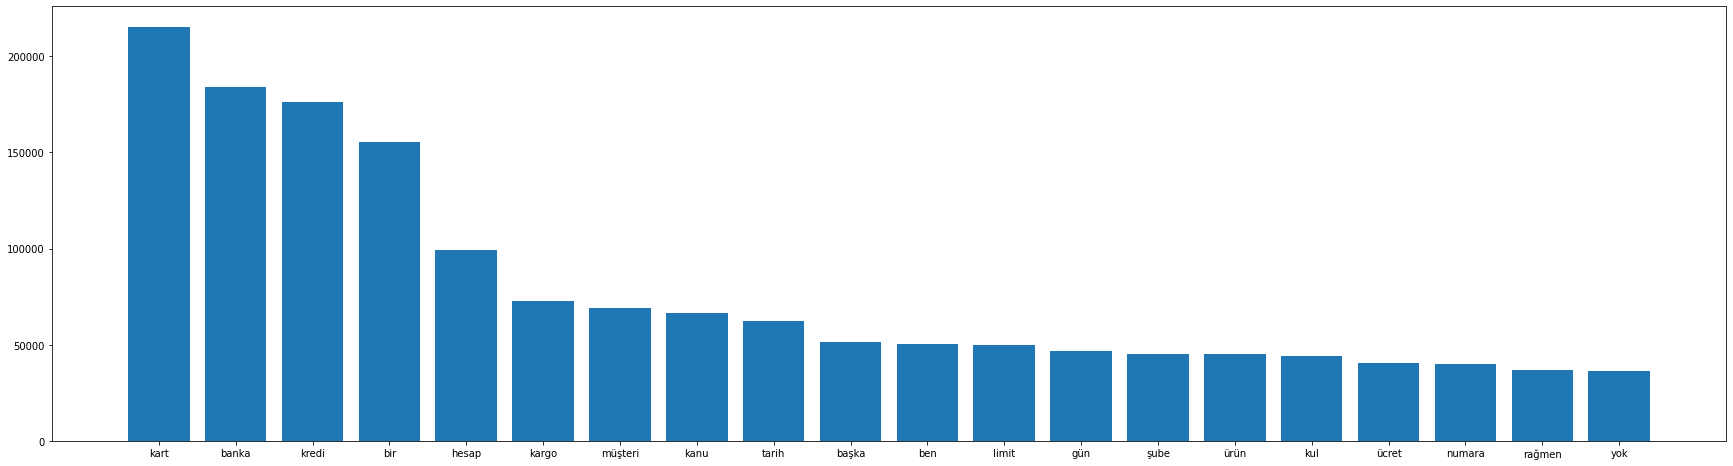

In [23]:
plt.figure(figsize = (30,8))
plt.bar(data.all_categories_word, data.all_categories_count)
plt.show()

- kart_count
- kredi_count
- diger_count
- hesap_count
- kargo_count
- limit_count
- musteri_count
- kkb_count

In [ ]:
nameList = ["kart","kredi","diger","hesap","kargo", "limit", "musteri", "kkb"]
dfList = [cartDf, creditDf, otherDf, accountDf, cargoDf, limitDf, customerDf, kkbDf]
for i in range(len(df.label.unique())):
  res = dfList[i].groupby([f"{nameList[i]}_word"])[f"{nameList[i]}_count"].sum().sort_values(ascending=False).head(10)
  print(res)
  print("------------------------------")

kart_word
kart       82564
banka      39586
kredi      31212
bir        20622
ücret      18590
müşteri    13276
aidat      11164
hesap      10236
tarih       8878
kul         8374
Name: kart_count, dtype: int64
------------------------------
kredi_word
kredi      52488
kart       40250
banka      39334
kanu       19536
bir        18528
tarih      11786
hesap      11488
madde      10862
müşteri     9890
yapı        7286
Name: kredi_count, dtype: int64
------------------------------
diger_word
banka    22788
bir      22034
kredi    21522
kanu     19640
kart     15146
diğer    14040
tarih    11496
madde    11306
başka     8788
ürün      8692
Name: diger_count, dtype: int64
------------------------------
hesap_word
hesap      55696
banka      28518
bir        25556
kart       18122
kredi      14250
numara     12040
başka      10020
ben         9874
müşteri     9188
par         8870
Name: hesap_count, dtype: int64
------------------------------
kargo_word
kargo      61062
bir        29920
ü

In [ ]:
def createWordCloud(words, label):
  plt.figure(figsize=(20,15))
  wordCloud = WordCloud(max_words = 100, max_font_size = 55)
  wordCloud.generate(words)
  plt.title(f"{label} Kategorisinde En Çok Geçen Kelimeler", fontsize = 20)
  plt.imshow(wordCloud.recolor(colormap='Blues', random_state=17), alpha=0.98)
  plt.axis('off')

In [ ]:
card = " ".join(df.loc[df.label == "Kart İşlemleri"]["text"].values)
credit = " ".join(df.loc[df.label == "Kredi İşlemleri"]["text"].values)
other = " ".join(df.loc[df.label == "Diğer"]["text"].values)
account = " ".join(df.loc[df.label == "Hesap İşlemleri"]["text"].values)
cargo = " ".join(df.loc[df.label == "Kargo"]["text"].values)
limit = " ".join(df.loc[df.label == "Limit"]["text"].values)
customer = " ".join(df.loc[df.label == "Müşteri Temsilcisi"]["text"].values)
kkb = " ".join(df.loc[df.label == "KKB Skor"]["text"].values)
labelValuesList = [card, credit, other, account, cargo, limit, customer, kkb]
labelList = [label for label in df.label.unique()]

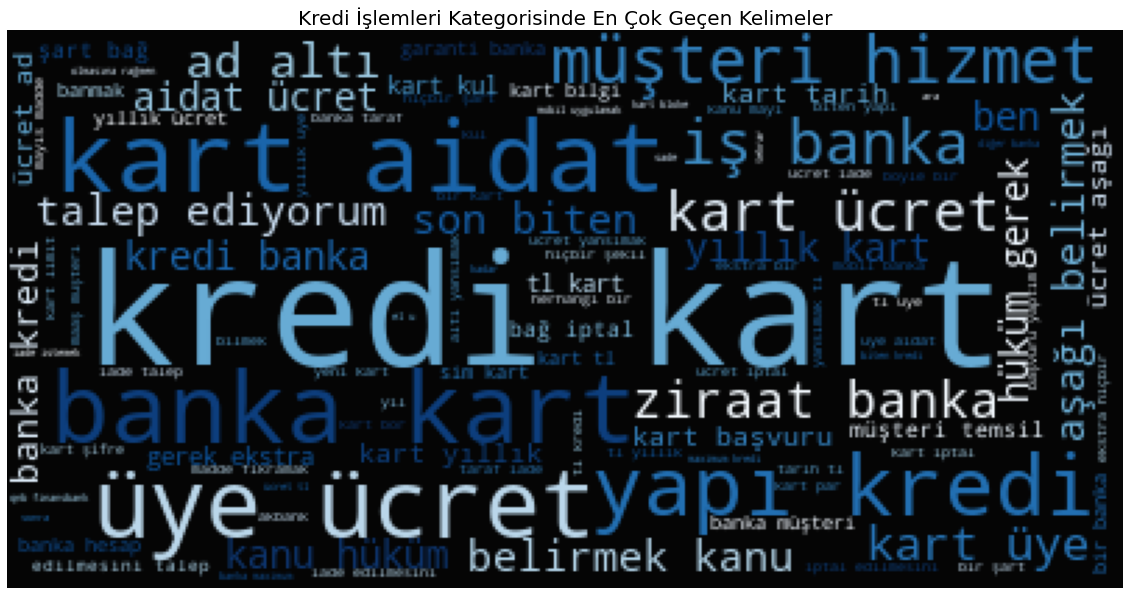

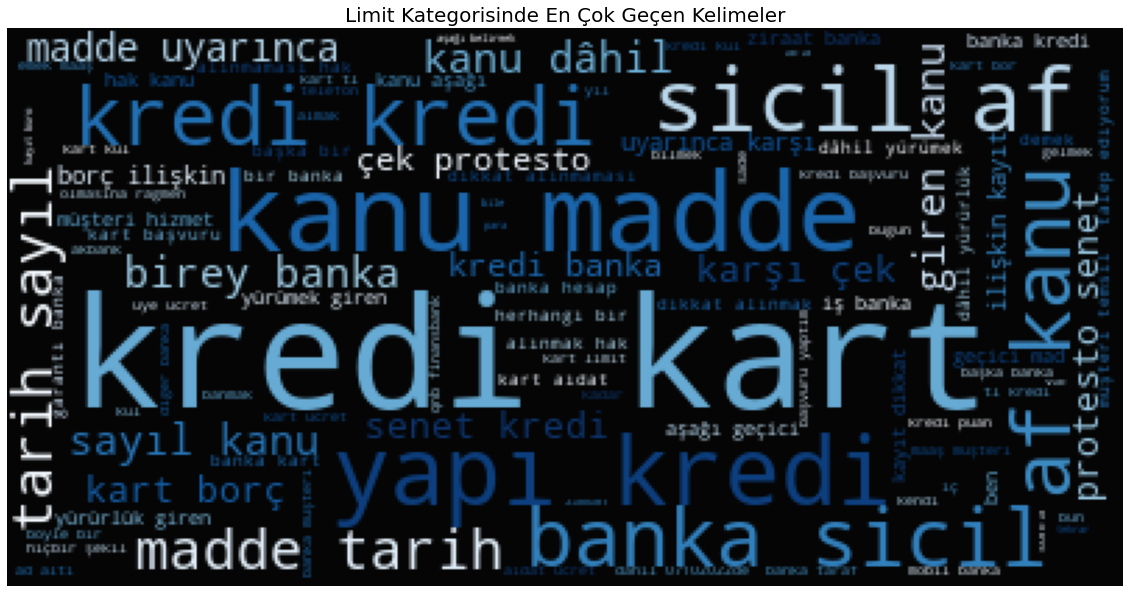

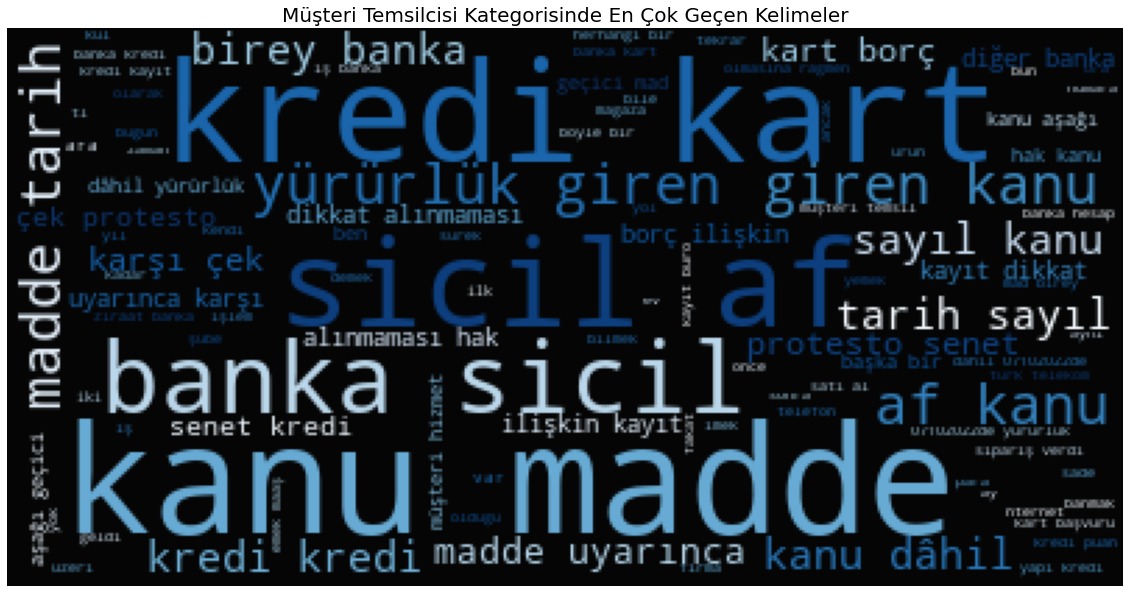

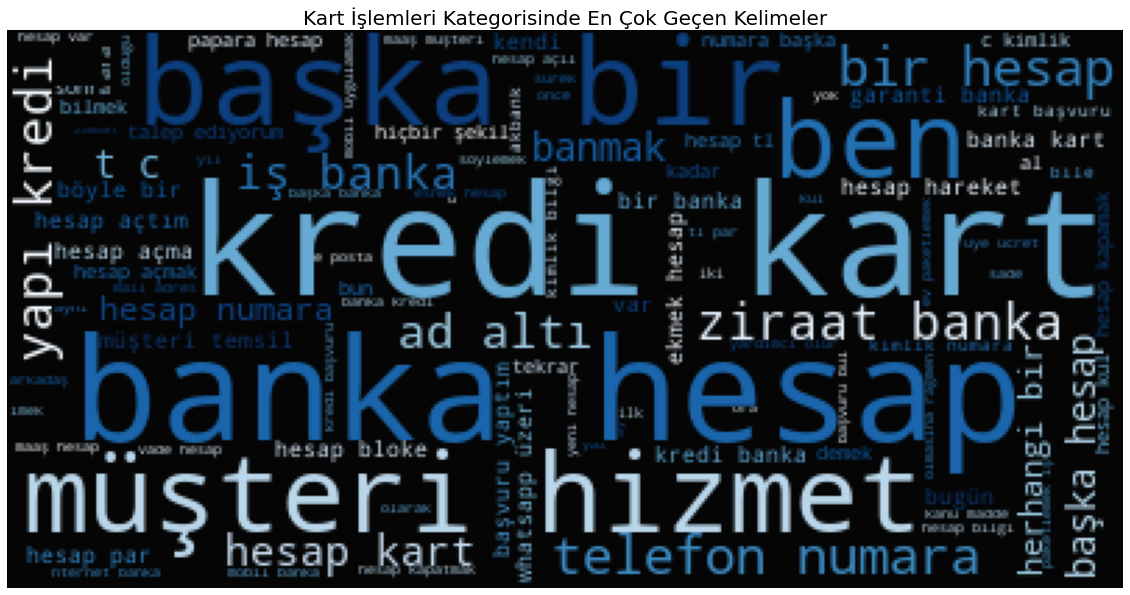

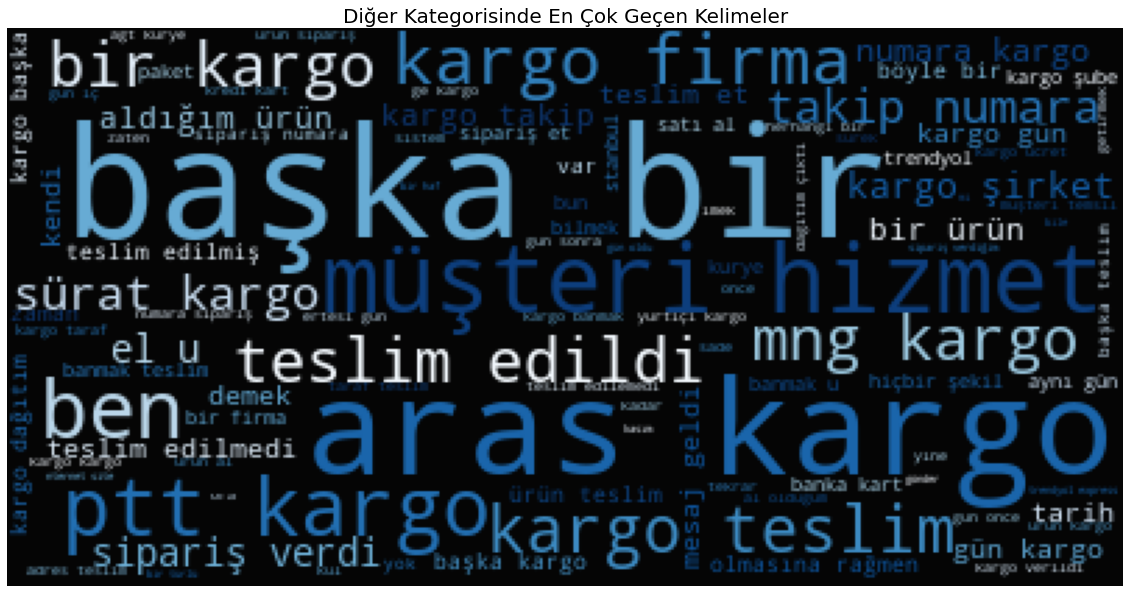

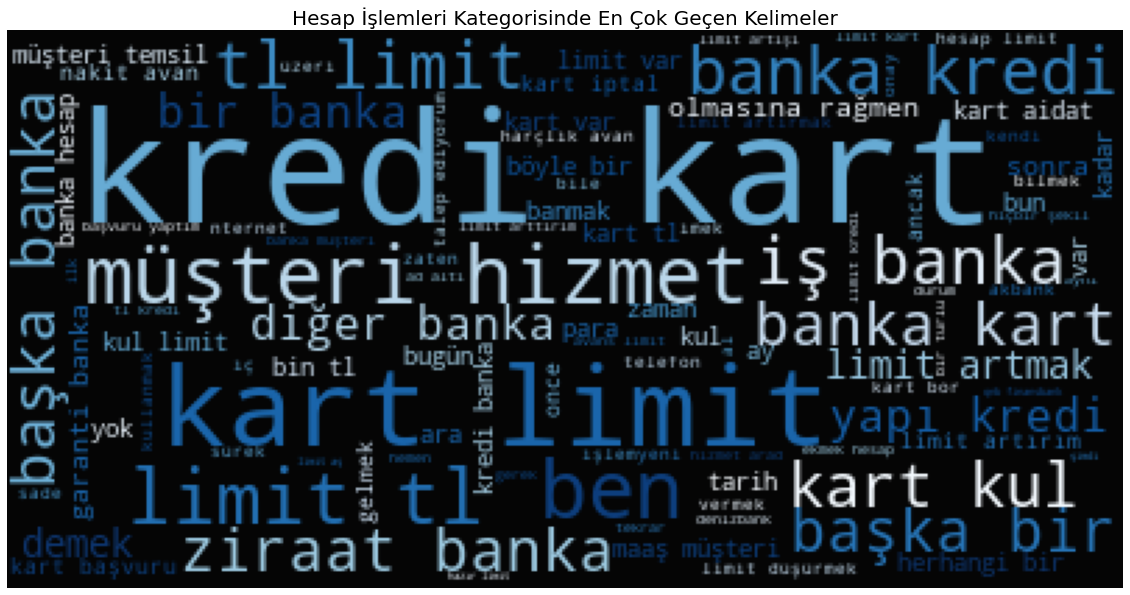

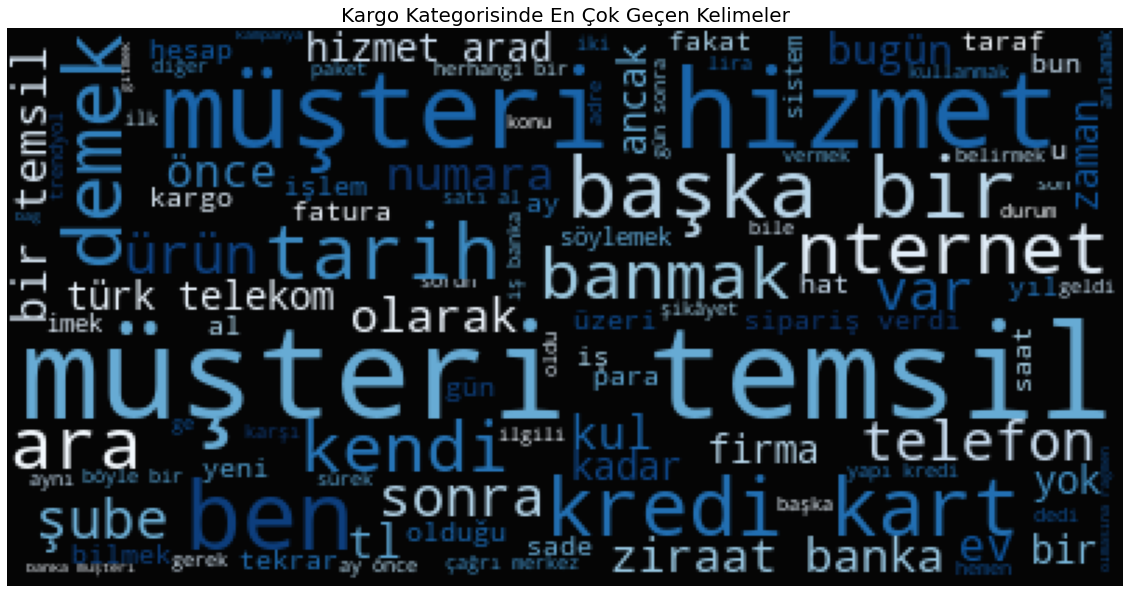

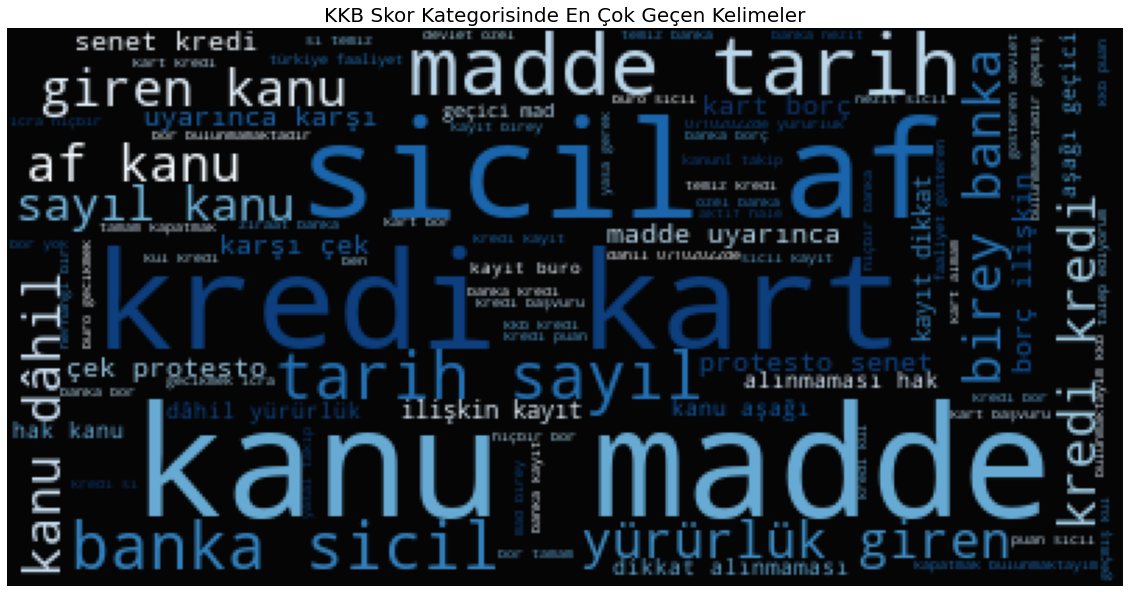

In [ ]:
for i in range(len(labelValuesList)):
   createWordCloud(labelValuesList[i], labelList[i])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.3, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((172488,), (73924,), (172488,), (73924,))

In [ ]:
lsvc = Pipeline([("vect", CountVectorizer(ngram_range=(1, 2), max_features=5000)),
                              ("tfidf", TfidfTransformer()),
                              ("clf", LinearSVC(dual=True, fit_intercept=True, loss="hinge"))])
lsvc.fit(x_train, y_train)
accuracy = lsvc.score(x_test, y_test)
print(f"Model Accuracy: {accuracy}")
y_pred = lsvc.predict(x_test)

Model Accuracy: 0.6878550944212976


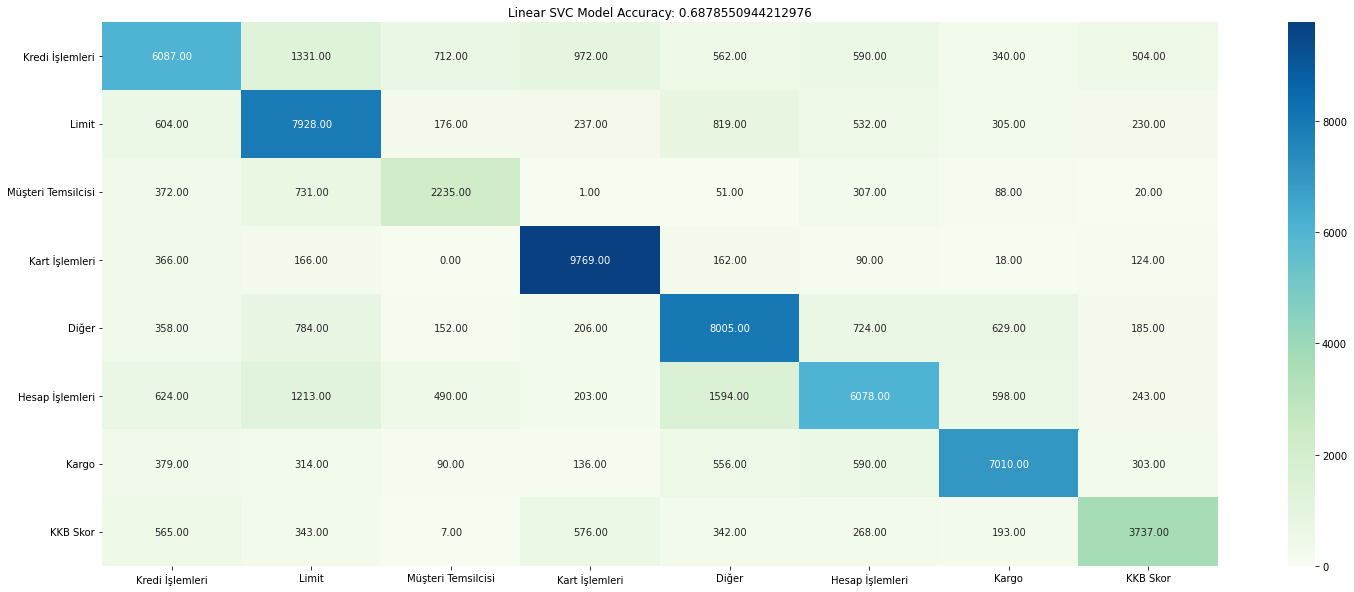

In [ ]:
def modelResultVisualization(y_test, y_pred, modelName, accuracy):
  plt.figure(figsize = (25,10))
  sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = ".2f",
              xticklabels = labelList, # labelList = [label for label in df.label.unique()]
              yticklabels = labelList, cmap = "GnBu")
  plt.title(f"{modelName} Model Accuracy: {accuracy}")
  plt.show()
modelResultVisualization(y_test, y_pred, "Linear SVC", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))  

                    precision    recall  f1-score   support

             Diğer       0.65      0.55      0.60     11098
   Hesap İşlemleri       0.62      0.73      0.67     10831
          KKB Skor       0.58      0.59      0.58      3805
             Kargo       0.81      0.91      0.86     10695
    Kart İşlemleri       0.66      0.72      0.69     11043
   Kredi İşlemleri       0.66      0.55      0.60     11043
             Limit       0.76      0.75      0.76      9378
Müşteri Temsilcisi       0.70      0.62      0.66      6031

          accuracy                           0.69     73924
         macro avg       0.68      0.68      0.68     73924
      weighted avg       0.69      0.69      0.68     73924



In [ ]:
# Hyperparameter Optimization with GridSearchCV for the Linear SVC Model
parameters = {
  'C' : [1, 5, 10],
  'loss' : ["hinge","squared_hinge"], 
  'dual' : [True, False],
  'multi_class' : ["ovr","crammer_singer"],
  'intercept_scaling' : [1, 5, 10, 20],
  'fit_intercept': [True, False]
}
lsvc = LinearSVC()
gscv = Pipeline([("vect", CountVectorizer(ngram_range=(1, 2), max_features=5000)),
                              ("tfidf", TfidfTransformer()),
                              ("clf", GridSearchCV(lsvc, parameters, n_jobs=-1, cv=3, scoring="roc_auc"))])
gscv.fit(x_train, y_train)
print(gscv.best_score_, "\n", gscv.best_params_)

Model Accuracy: 0.6814025215085764


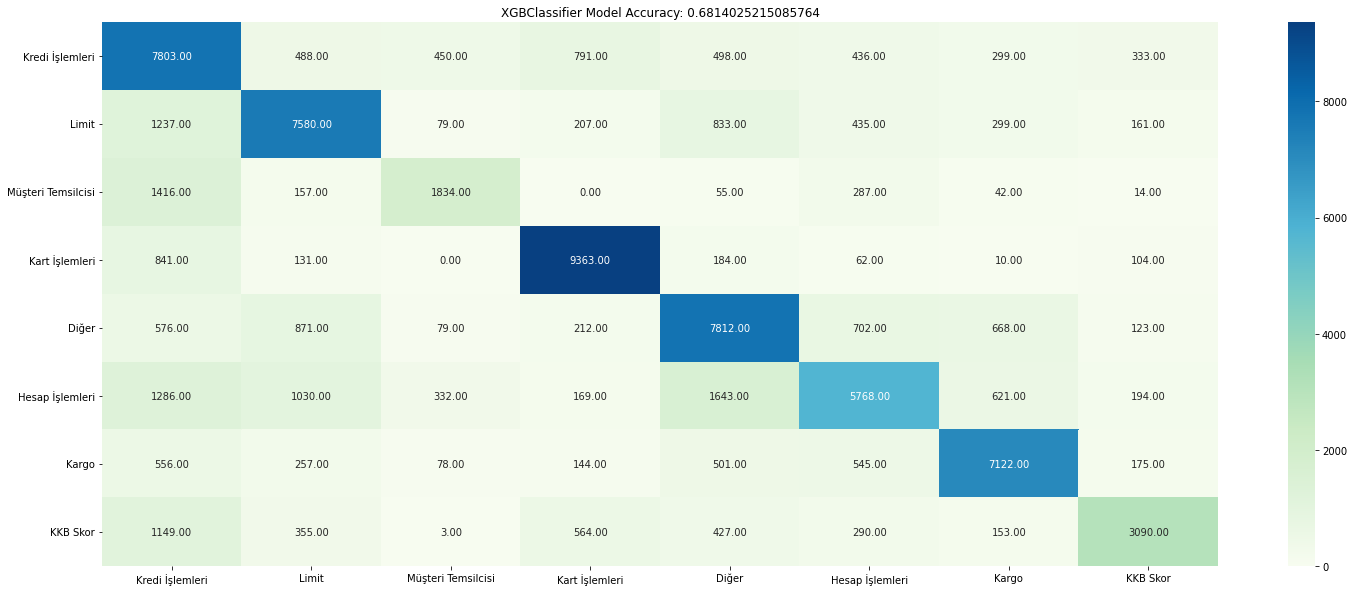

In [ ]:
xgb = Pipeline([("vect", CountVectorizer(ngram_range=(1, 2), max_features=5000)),
                              ("tfidf", TfidfTransformer()),
                              ("clf", XGBClassifier(objective='multi:softprob'))])
xgb.fit(x_train, y_train)
accuracy = xgb.score(x_test, y_test)
print(f"Model Accuracy: {accuracy}")
y_pred = xgb.predict(x_test)
modelResultVisualization(y_test, y_pred, "XGBClassifier", accuracy)

In [ ]:
# Hyperparameter Optimization with GridSearchCV for the XGBClassifier Model 
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}


# Init classifier
xgb_cl = XGBClassifier(objective='multi:softprob')

gscv = Pipeline([("vect", CountVectorizer(ngram_range=(1, 2), max_features=5000)),
                              ("tfidf", TfidfTransformer()),
                              ("clf", GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc"))])

# Fit
gscv.fit(x_train, y_train)

Model Accuracy: 0.685771873816352


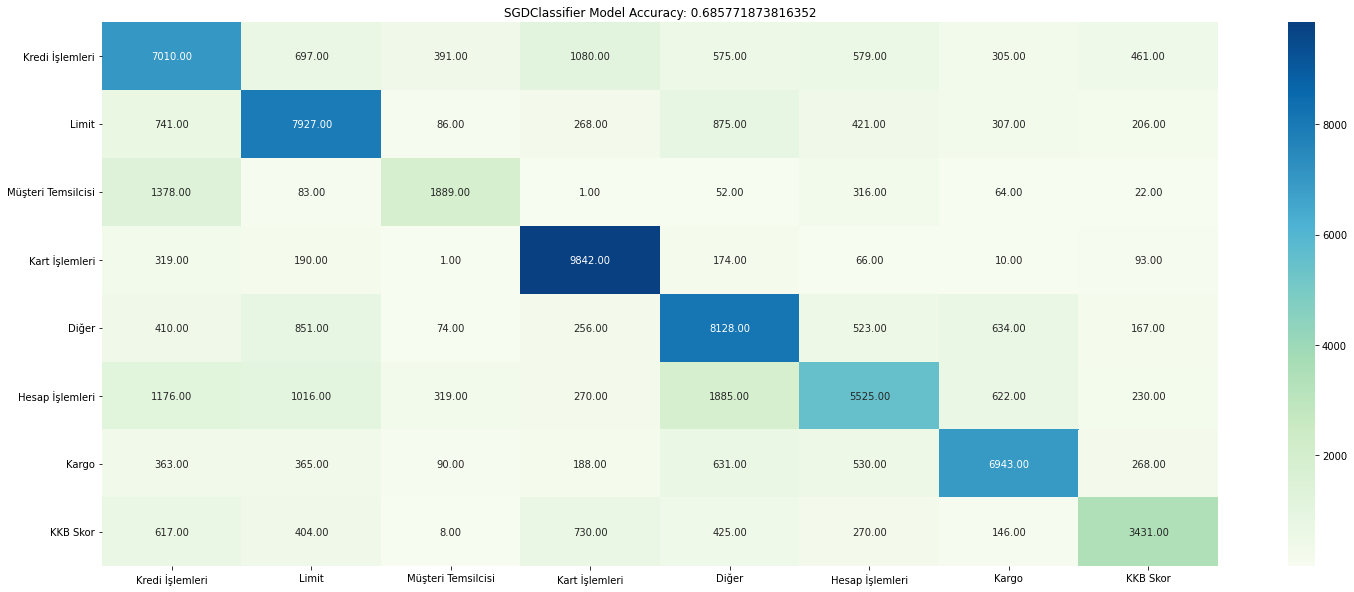

In [ ]:
sgd = Pipeline([("vect", CountVectorizer(ngram_range=(1, 2), max_features=5000)),
                              ("tfidf", TfidfTransformer()),
                              ("clf", SGDClassifier())])
sgd.fit(x_train, y_train)
accuracy = sgd.score(x_test, y_test)
print(f"Model Accuracy: {accuracy}")
y_pred = sgd.predict(x_test)
modelResultVisualization(y_test, y_pred, "SGDClassifier", accuracy)

Model Accuracy: 0.7057247984416428


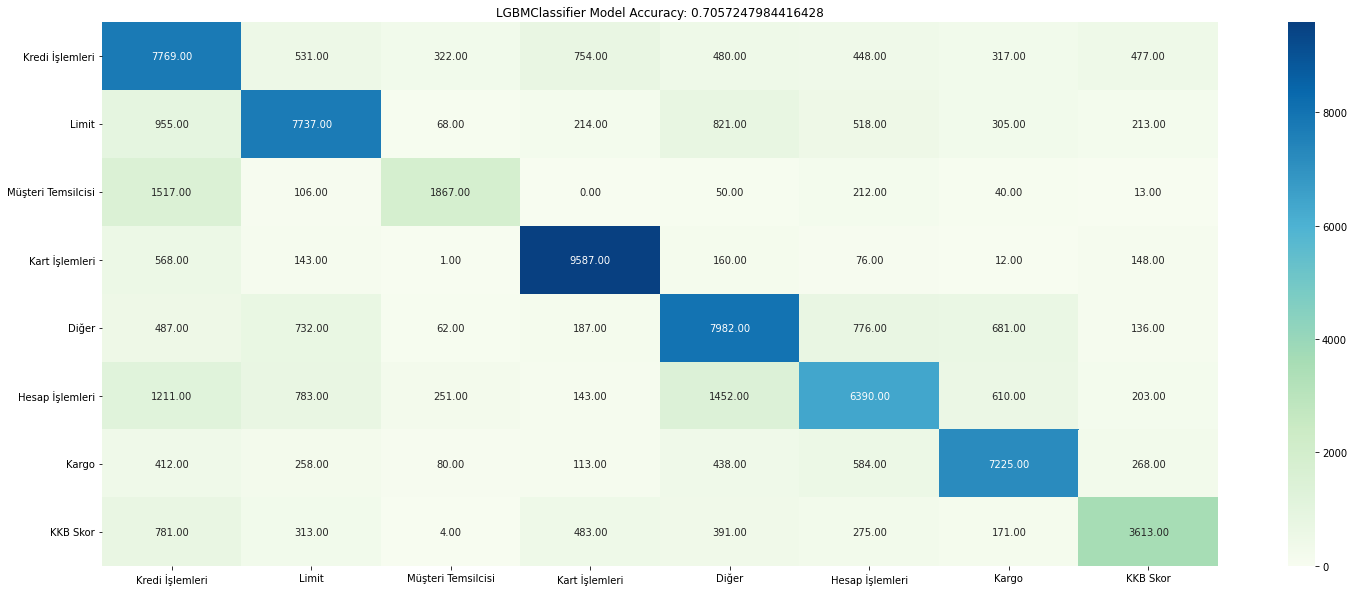

In [ ]:
lgbm = Pipeline([("vect", CountVectorizer(ngram_range=(1, 2), max_features=5000)),
                              ("tfidf", TfidfTransformer()),
                              ("clf", LGBMClassifier())])
lgbm.fit(x_train, y_train)
accuracy = lgbm.score(x_test, y_test)
print(f"Model Accuracy: {accuracy}")
y_pred = lgbm.predict(x_test)
modelResultVisualization(y_test, y_pred, "LGBMClassifier", accuracy)

Model Accuracy: 0.7314403982468481


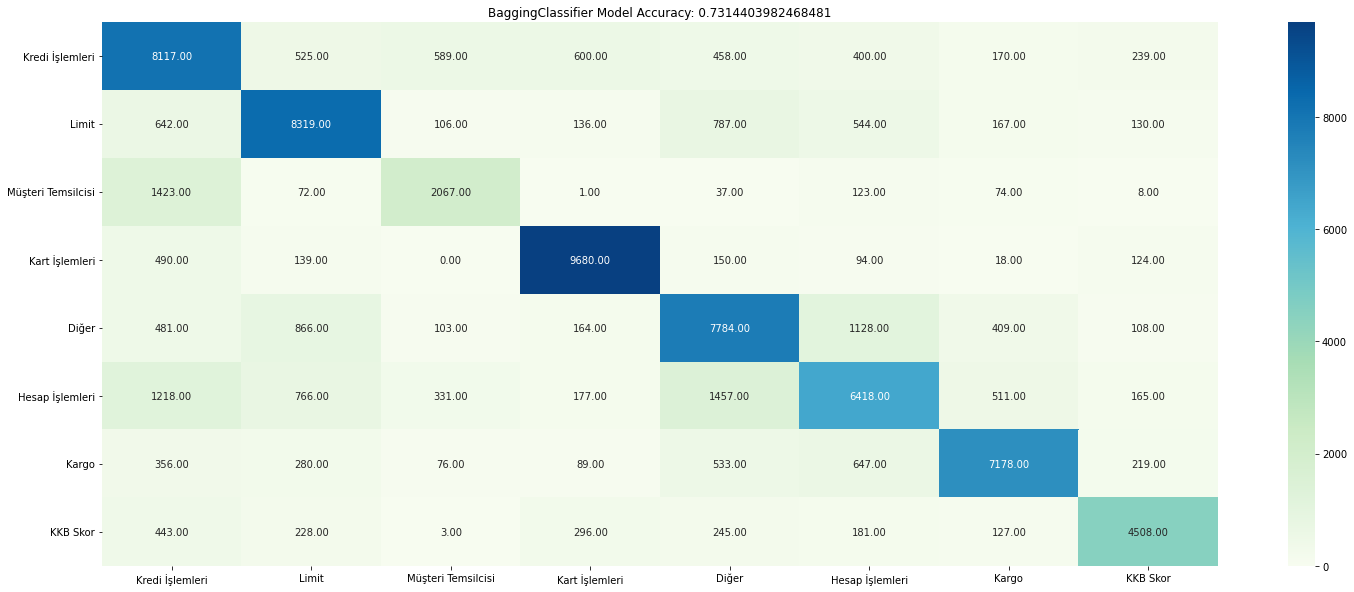

In [ ]:
bagging = Pipeline([("vect", CountVectorizer(ngram_range=(1, 2), max_features=5000)),
                              ("tfidf", TfidfTransformer()),
                              ("clf", BaggingClassifier())])
bagging.fit(x_train, y_train)
accuracy = bagging.score(x_test, y_test)
print(f"Model Accuracy: {accuracy}")
y_pred = bagging.predict(x_test)
modelResultVisualization(y_test, y_pred, "BaggingClassifier", accuracy)